In [2]:
import oLIMpus
from oLIMpus.maps_LIM import CoevalBox_LIM_zeuslike, CoevalBoxes_percell
from oLIMpus.fiducial_analysis import * 
from zeus21 import maps as zeus21_maps, cosmology
from oLIMpus.LIM import LineLuminosity, get_LIM_coefficients
from zeus21.correlations import Correlations, Power_Spectra
from oLIMpus.correlations_LIM import Correlations_LIM, Power_Spectra_LIM
import astropy.units as au  

In [3]:
Lbox = 50#600
Ncell = 50#150
ZMIN = 5.0 #down to which z we compute the evolution

In [4]:
#set up your parameters here
CosmoParams_input = oLIMpus.Cosmo_Parameters_Input()

#set up the CLASS cosmology
from classy import Class
ClassCosmo = Class()
ClassCosmo.compute()

ClassyCosmo = oLIMpus.runclass(CosmoParams_input) 
print('CLASS has run, we store the cosmology.')

CLASS has run, we store the cosmology.


In [5]:
CosmoParams = oLIMpus.Cosmo_Parameters(CosmoParams_input, ClassyCosmo) 
HMFintclass = oLIMpus.HMF_interpolator(CosmoParams,ClassyCosmo)
print('HMF interpolator built. This ends the cosmology part -- moving to astrophysics.')

HMF interpolator built. This ends the cosmology part -- moving to astrophysics.


In [6]:
#set up your astro parameters too, here the peak of f*(Mh) as an example
AstroParams = oLIMpus.Astro_Parameters(CosmoParams,STOCHASTICITY=False,second_order_SFRD=False)


In [7]:
OIII_Yang_input = oLIMpus.LineParams_Input(\
                 LINE = 'OIII',
                 nu_rest = 6.042e14, 
                 OBSERVABLE_LIM = 'Inu',
                 _R = Lbox/Ncell,
                 LINE_MODEL = 'Yang24',
                 sigma_LSFR = 0.)
OIII_Yang = oLIMpus.Line_Parameters(OIII_Yang_input) 

Ha_Nion_input = oLIMpus.LineParams_Input(\
                 LINE = 'Ha',
                 nu_rest = 4.57e14, 
                 OBSERVABLE_LIM = 'Inu',
                 _R = Lbox/Ncell,
                 LINE_MODEL = 'Nionrate',
                 sigma_LSFR = 0.)
Ha_Nion = oLIMpus.Line_Parameters(Ha_Nion_input) 

Your resolution introduces too large non linear corrections on small scales! 
We use instead MIN_R_NONLINEAR = 2 Mpc
Your resolution introduces too large non linear corrections on small scales! 
We use instead MIN_R_NONLINEAR = 2 Mpc


In [8]:
get_z = 7.
seed = 1065
_islice = 0
RSDMODE = 0 

In [9]:
correlations = oLIMpus.Correlations(CosmoParams, ClassyCosmo)   
coefficients = oLIMpus.get_T21_coefficients(CosmoParams, ClassyCosmo, AstroParams, HMFintclass, zmin=ZMIN)

PS21 = oLIMpus.Power_Spectra(CosmoParams, AstroParams, ClassyCosmo, correlations, coefficients, RSD_MODE = RSDMODE)

BMF_val = oLIMpus.BMF(coefficients, HMFintclass,CosmoParams,AstroParams)

In [10]:
delta_box = zeus21_maps.CoevalMaps(coefficients,PS21,get_z,Lbox,Ncell,1,seed).deltamap

In [11]:
ir = idx = np.abs(CosmoParams._Rtabsmoo - Lbox/Ncell).argmin()
print(Lbox/Ncell,CosmoParams._Rtabsmoo[ir])

1.0 1.062747283529282


In [18]:
AstroParams.N_ion_perbaryon_II/cosmology.rho_baryon(CosmoParams,0.)/ oLIMpus.sfrd.fesc_II(AstroParams, HMFintclass.Mhtab)

array([8.03546094e-06, 8.03546094e-06, 8.03546094e-06, 8.03546094e-06,
       8.03546094e-06, 8.03546094e-06, 8.03546094e-06, 8.03546094e-06,
       8.03546094e-06, 8.03546094e-06, 8.03546094e-06, 8.03546094e-06,
       8.03546094e-06, 8.03546094e-06, 8.03546094e-06, 8.03546094e-06,
       8.03546094e-06, 8.03546094e-06, 8.03546094e-06, 8.03546094e-06,
       8.03546094e-06, 8.03546094e-06, 8.03546094e-06, 8.03546094e-06,
       8.03546094e-06, 8.03546094e-06, 8.03546094e-06, 8.03546094e-06,
       8.03546094e-06, 8.03546094e-06, 8.03546094e-06, 8.03546094e-06,
       8.03546094e-06, 8.03546094e-06, 8.03546094e-06])

In [ ]:
_iz = min(range(len(coefficients.zintegral)), key=lambda i: np.abs(coefficients.zintegral[i]-get_z))

# see how to smooth density field
Rs = coefficients.Rtabsmoo
r_precision = 1.
r_idx = np.linspace(0,len(Rs)-1,int(len(Rs)*r_precision),dtype=int)
r = Rs[r_idx]
sphere_FACTOR = 0.620350491 # factor relating cube length to filter radius = (4PI/3)^(-1/3)
ir = np.abs(r - (Lbox/Ncell) * sphere_FACTOR).argmin()

Nion_rate = BMF_val.niondot_delta_r(delta_box.flatten(),ir)*AstroParams.N_ion_perbaryon_II/cosmology.rho_baryon(CosmoParams,0.)
Nion_rate = (Nion_rate.reshape((Ncell,Ncell,Ncell,len(coefficients.zintegral)))*(au.yr**-1)).to(au.s**-1) / oLIMpus.sfrd.fesc_II(AstroParams, HMFintclass.Mhtab)
print(Nion_rate)

[[[[2.09908182e-22 2.04866727e-22 1.99696245e-22 ... 1.93124379e-30
    1.04514992e-30 5.54991892e-31]
   [1.46871069e-22 1.43074539e-22 1.39157809e-22 ... 2.27830859e-31
    1.16279135e-31 5.81070352e-32]
   [2.76080209e-22 2.69867124e-22 2.63528475e-22 ... 1.00000650e-29
    5.66077129e-30 3.14941295e-30]
   ...
   [2.58707045e-23 2.50173053e-23 2.41180914e-23 ... 7.51852485e-36
    2.88591817e-36 1.07346588e-36]
   [8.66302346e-23 8.41783408e-23 8.16300542e-23 ... 9.77334145e-33
    4.57415188e-33 2.08952327e-33]
   [2.35358861e-22 2.29852034e-22 2.24216151e-22 ... 3.83605348e-30
    2.11535361e-30 1.14537081e-30]]

  [[5.52742492e-22 5.42693115e-22 5.32627276e-22 ... 6.57714921e-28
    4.17250337e-28 2.61249906e-28]
   [2.30580100e-22 2.25159181e-22 2.19609075e-22 ... 3.39186668e-30
    1.86412489e-30 1.00582532e-30]
   [2.74897974e-22 2.68704771e-22 2.62385844e-22 ... 9.74550964e-30
    5.51279009e-30 3.06484393e-30]
   ...
   [3.02537790e-22 2.95888963e-22 2.89118943e-22 ... 1.73

In [23]:
frec = 0.45
hP = 1.73094832e-60 # units of Lsun * s / Hz

variance = np.var(delta_box)
sigmaR = np.sqrt(variance)
deltaArray = delta_box * sigmaR
mArray, deltaArray_Mh = np.meshgrid(HMFintclass.Mhtab, deltaArray, indexing = 'ij', sparse = True)

sigmaM = HMFintclass.sigmaintlog((np.log(mArray),get_z))

modSigmaSq = sigmaM**2 - sigmaR**2
indexTooBig = (modSigmaSq <= 0.0)
modSigmaSq[indexTooBig] = np.inf #if sigmaR > sigmaM the halo does not fit in the radius R. Cut the sum
modSigma = np.sqrt(modSigmaSq)

nu0 = CosmoParams.delta_crit_ST / sigmaM
nu0[indexTooBig] = 1.0
modd = CosmoParams.delta_crit_ST - deltaArray_Mh
nu = modd / modSigma

EPS_HMF_corr = (nu/nu0) * (sigmaM/modSigma)**2.0 * np.exp(-CosmoParams.a_corr_EPS * (nu**2-nu0**2)/2.0 ) * (1.0 + deltaArray_Mh)

HMF_curr = np.exp(HMFintclass.logHMFint((np.log(mArray),get_z)))

_iz = min(range(len(coefficients.zintegral)), key=lambda i: np.abs(coefficients.zintegral[i]-get_z))
L_Halpha = hP * Ha_Nion.nu_rest * frec * Nion_rate[:,:,:,_iz] # Hz * s-1

integrand_LIM = EPS_HMF_corr *  HMF_curr * L_Halpha.flatten() * HMFintclass.Mhtab[:,np.newaxis] / oLIMpus.sfrd.fesc_II(AstroParams, HMFintclass.Mhtab)[:,np.newaxis] # !!!! fesc !!! 

rhoLbox_flattened = np.trapezoid(integrand_LIM,HMFintclass.logtabMh, axis = 0)

rhoL_box = rhoLbox_flattened.reshape(Ncell,Ncell,Ncell).value

coeff1_LIM =  ((((oLIMpus.constants.c_kms * au.km/au.s) / (4*np.pi * (cosmology.Hub(CosmoParams, get_z) * au.km/au.s/au.Mpc) * Ha_Nion.nu_rest * au.Hz)) * au.Lsun / au.Mpc**3/au.steradian).to(au.Jy/au.steradian)).value

Inu_box = rhoL_box * coeff1_LIM

In [24]:
coeval_slice_line =  Inu_box[_islice]
coeval_slice_line

array([[6.90452305e-69, 4.33601469e-69, 9.87713147e-69, ...,
        4.57947753e-70, 2.18487533e-69, 8.01717445e-69],
       [2.45970534e-68, 7.80521778e-69, 9.82182334e-69, ...,
        1.11343538e-68, 3.47761641e-68, 5.72189194e-68],
       [3.20923418e-68, 4.54542142e-69, 3.13529926e-69, ...,
        9.98835938e-68, 2.12564643e-67, 1.63121276e-67],
       ...,
       [1.20536461e-68, 7.34677289e-69, 7.48179266e-69, ...,
        1.07804751e-68, 1.45957694e-68, 1.73260648e-68],
       [5.13470239e-69, 3.37161452e-69, 5.18466233e-69, ...,
        8.32005029e-70, 2.23285044e-69, 5.68497481e-69],
       [2.89581019e-69, 2.20238908e-69, 5.37986177e-69, ...,
        1.26706474e-70, 5.98368413e-70, 2.65834377e-69]], shape=(50, 50))

In [25]:
Maps_T21 = oLIMpus.maps.T21_bubbles(coefficients,PS21,get_z,Lbox,Ncell,seed,correlations,CosmoParams,AstroParams,ClassyCosmo,BMF_val)

coeval_slice_xH = Maps_T21.xHI_map[_islice]


Text(0.05, 0.05, '$x_{\\rm H}$')

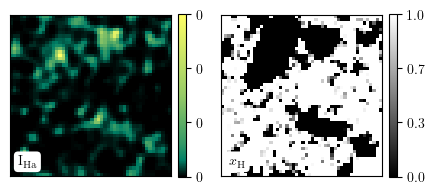

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))

im = ax[0].imshow(coeval_slice_line,extent=(0,Lbox,0,Lbox),cmap=LIM_colour_1)
cbar = fig.colorbar(im, ax=ax[0], fraction=0.046, pad=0.04, format="%.0e")
ax[0].set_xticks([])
ax[0].set_yticks([])

xticks = np.linspace(np.min(coeval_slice_line),np.max(coeval_slice_line),4)
array_ticks = np.vectorize(lambda x: f"{x:.0f}")(xticks)

cbar.set_ticks(xticks, labels = array_ticks)

text_label_helper = r'$\rm I_{%s}$'%Ha_Nion.LINE
text_label = text_label_helper


ax[0].text(
    0.05, 0.05, text_label, 
    color='black',
    fontsize=10,
    ha='left', va='bottom',
    transform=ax[0].transAxes,  # Coordinates relative to the axis (0 to 1)
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3')  # White rounded background
)


im = ax[1].imshow(coeval_slice_xH,extent=(0,Lbox,0,Lbox),cmap='gray',vmin=0,vmax=1)
cbar = fig.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04, format="%.0e")
ax[1].set_xticks([])
ax[1].set_yticks([])

xticks = np.linspace(0,1,4)
array_ticks = np.vectorize(lambda x: f"{x:.1f}")(xticks)

cbar.set_ticks(xticks, labels = array_ticks)

text_label_helper = r'$x_{\rm H}$'
text_label = text_label_helper


ax[1].text(
    0.05, 0.05, text_label, 
    color='black',
    fontsize=10,
    ha='left', va='bottom',
    transform=ax[1].transAxes,  # Coordinates relative to the axis (0 to 1)
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3')  # White rounded background
)
